In [22]:
print ("David Guzman 11/16/21")

David Guzman 11/16/21


# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [33]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [34]:
# Calculate effect size based on our expected rates
# the two expected rates, 6% (0.06),9% (0.09)
# effect size for a test comparing two proportions 

effect_size = sms.proportion_effectsize(0.06, 0.09)


In [35]:
# Calculate sample size needed
# ceil will round up the number 
# need to use .05 for the alpha
# set power to .8, if there is a difference in conversion 
# rate between our designs, there is 80% chance to detect
# it as statisically significant 

required_n = sms.NormalIndPower().solve_power( 
    effect_size, power = 0.8, alpha=0.05, ratio=1)

required_n = ceil(required_n)
print (required_n)

1199


### Collecting and preparing the data

In [36]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv("tiktok_data.csv")
df.head()


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [37]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [38]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df["group"],df["button"])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [39]:
# Check that no users have been sampled multiple times 
session_counts = df["user_id"].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print (multi_users) # there are 3453 users are being sampled twice, lets remove them



3453


In [40]:
# If there are users who have been sampled multiple times, remove them from the dataframe
users_to_drop = session_counts[session_counts > 1].index
df = df[~df["user_id"].isin(users_to_drop)]
print(df.shape[0])


268875


In [42]:
# remove the users who appeared in the wrong test group
df_control = df.loc[(df["group"] == "control")]
df_control = df_control [df.button != "star"]

df_treat = df.loc[(df["group"] == "treatment")]
df_treat = df_treat[df.button != "heart"]  

df_clean = pd.concat([df_control, df_treat], ignore_index=True)

df = df_clean

<ipython-input-42-580f457678ca>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control [df.button != "star"] #old
<ipython-input-42-580f457678ca>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.button != "heart"] # new


In [43]:
# check that control is seeing heart and treatment is star
pd.crosstab(df["group"], df["button"])

button,heart,star
group,,
control,134233,0
treatment,0,134423


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [44]:
# Perform simple random sampling to split the data into control and treatment
control_sample = df[df["group"] == "control"].sample(n=required_n, random_state=22)
treatment_sample = df[df["group"] == "treatment"].sample(n=required_n, random_state=22)


In [45]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test


,user_id,timestamp,group,button,liked
0,917088,2017-01-12 13:49:24,control,heart,1
1,916840,2017-01-20 5:22:05,control,heart,0
2,711894,2017-01-09 21:35:00,control,heart,0
3,929441,2017-01-11 14:17:55,control,heart,1
4,906207,2017-01-10 17:55:40,control,heart,0
...,...,...,...,...,...
2393,829862,2017-01-20 7:22:43,treatment,star,0
2394,700306,2017-01-23 15:52:38,treatment,star,1
2395,803106,2017-01-11 11:07:57,treatment,star,0
2396,755046,2017-01-14 15:33:20,treatment,star,1


In [46]:
# Count the test groups to make sure that they're balanced 
ab_test["group"].value_counts() # it is balanced 1199, 1199


treatment    1199
control      1199
Name: group, dtype: int64

### Analysis Visualization

In [47]:
# Find the like rate by group
conversion_rates = ab_test.groupby("group")["liked"]

# Find the Std. deviation of the proportion
std_p = lambda x: np.std(x)
# Find the Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x)

# Calculate the final like rate
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ["conversion_rate", "std_deviation", "std_error"]

conversion_rates.style.format ('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.319,0.009
treatment,0.116,0.320,0.009


Text(0, 0.5, 'Converted (Proportion)')

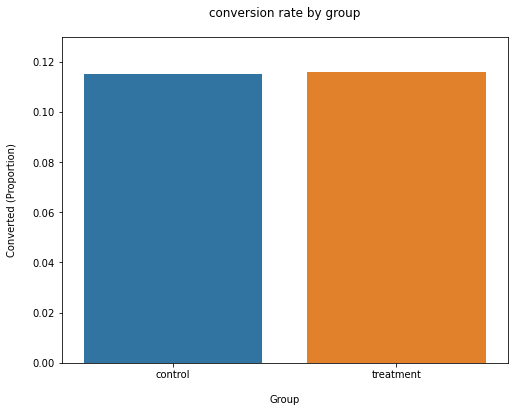

In [51]:
# Plot the like rate by group on a bar plot
plt.figure(figsize= (8,6))

sns.barplot(x=ab_test["group"], y=ab_test["liked"], ci=False)
plt.ylim(0, 0.13)
plt.title("conversion rate by group", pad = 20)
plt. xlabel("Group", labelpad=15)
plt.ylabel("Converted (Proportion)", labelpad=15)

### Testing for Stat Sig

In [52]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test["group"]== "control"] ["liked"]
treatment_results = ab_test[ab_test["group"] == "treatment"] ["liked"]

# Get the number of samples in both groups
n_con = control_results.count()
n_treat = treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print(n_con)
print(n_treat)
print(successes)
print(nobs)


1199
1199
[138, 139]
[1199, 1199]


In [53]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(successes, nobs=nobs)


# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha = 0.05)


In [54]:
# print z statistic
print(f"z_statistics: {z_stat:.2f}")

# print p-value
print(f"p-value: {pval:3f}")

# print ci 95% for control group
print(f"ci 95% for control group:[{lower_con:.3f}, {upper_con:.3f}]")

# print ci 95% for treatment group
print(f"ci 95% for treatment group: [{lower_treat: .3f}, {upper_treat: 3f}]")

z_statistics: -0.06
p-value: 0.949060
ci 95% for control group:[0.097, 0.133]
ci 95% for treatment group: [ 0.098,  0.134051]


In [56]:
conversion_rates.style.format("{:.3f}")

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.319,0.009
treatment,0.116,0.320,0.009


### Were the results signficant? 

In [57]:
print ("the change is not significant")

the change is not significant


### What would you advise the engineering team to do moving forward?

In [58]:
print("I would advise that the engineering team to keep the heart")

I would advise that the engineering team to keep the heart
